In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

## Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448'
bucket = s3.Bucket(bucket_name)

## Defining the file to be read from s3 bucket
file_key = 'Chapter4/insurance.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

## Reading the csv file
insurance = pd.read_csv(file_content_stream)
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
## Changing labels to numbers 
insurance['sex'] = np.where(insurance['sex'] == 'female', 0, 1)
insurance['smoker'] = np.where(insurance['smoker'] == 'no', 0, 1)

## Extracting region dummies
region_dummies = pd.get_dummies(insurance['region']).iloc[:, 0:3]

## Appending dummies 
insurance = pd.concat([insurance, region_dummies], axis = 1)

insurance.head()

,age,sex,bmi,children,smoker,region,charges,northeast,northwest,southeast
0,19,0,27.900,0,1,southwest,16884.92400,0,0,0
1,18,1,33.770,1,0,southeast,1725.55230,0,0,1
2,28,1,33.000,3,0,southeast,4449.46200,0,0,1
3,33,1,22.705,0,0,northwest,21984.47061,0,1,0
4,32,1,28.880,0,0,northwest,3866.85520,0,1,0


[Text(697.5, 713.475, 'smoker <= 0.5\nmse = 147318719.48\nsamples = 1070\nvalue = 13325.331'),
 Text(348.75, 509.625, 'age <= 42.5\nmse = 37135017.666\nsamples = 856\nvalue = 8572.027'),
 Text(174.375, 305.775, 'age <= 22.5\nmse = 22653840.13\nsamples = 472\nvalue = 5461.764'),
 Text(87.1875, 101.92499999999995, 'mse = 23131188.02\nsamples = 141\nvalue = 3468.519'),
 Text(261.5625, 101.92499999999995, 'mse = 20037115.2\nsamples = 331\nvalue = 6310.85'),
 Text(523.125, 305.775, 'age <= 51.5\nmse = 28428583.373\nsamples = 384\nvalue = 12395.06'),
 Text(435.9375, 101.92499999999995, 'mse = 23557837.696\nsamples = 166\nvalue = 10425.14'),
 Text(610.3125, 101.92499999999995, 'mse = 26932468.193\nsamples = 218\nvalue = 13895.09'),
 Text(1046.25, 509.625, 'bmi <= 29.972\nmse = 136175528.411\nsamples = 214\nvalue = 32338.548'),
 Text(871.875, 305.775, 'age <= 41.0\nmse = 22281630.958\nsamples = 100\nvalue = 21380.49'),
 Text(784.6875, 101.92499999999995, 'mse = 13149178.139\nsamples = 58\nvalu

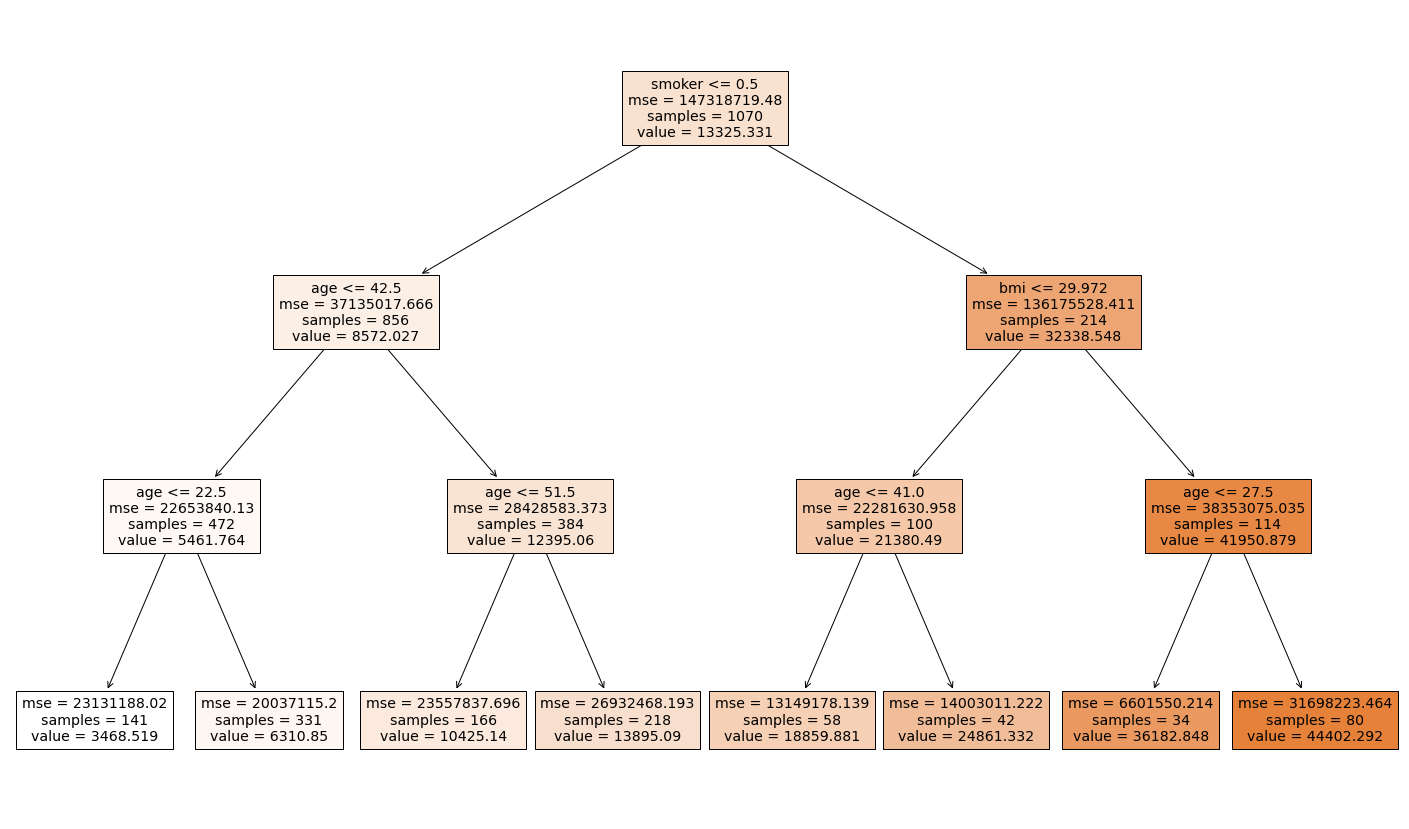

In [10]:
## Defining the input and target variables
X = insurance.drop(columns = ['charges', 'region'], axis = 1)
Y = insurance['charges']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True)

In [11]:
## Forcing to be data-frames
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

## Engineering features from decision-tree
X_train['interaction_1'] = np.where((X_train['smoker'] == 0) & (X_train['age'] <= 32.5), 1, 0)
X_train['interaction_2'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 32.5) & (X_train['age'] <= 44.5), 1, 0)
X_train['interaction_3'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 44.5) & (X_train['age'] < 51.5), 1, 0)
X_train['interaction_4'] = np.where((X_train['smoker'] == 0) & (X_train['age'] > 51.5), 1, 0)

X_test['interaction_1'] = np.where((X_test['smoker'] == 0) & (X_test['age'] <= 32.5), 1, 0)
X_test['interaction_2'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 32.5) & (X_test['age'] <= 44.5), 1, 0)
X_test['interaction_3'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 44.5) & (X_test['age'] < 51.5), 1, 0)
X_test['interaction_4'] = np.where((X_test['smoker'] == 0) & (X_test['age'] > 51.5), 1, 0)

In [6]:
## Fitting random forest model 
RF = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)

## Predicting on the test
RF_pred = RF.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, RF_pred))

22793520.81729277


In [7]:
## Fitting the xgboost model 
xgb = XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', n_estimators = 500, max_depth = 3, learning_rate = 0.01, n_jobs = -1).fit(X_train, Y_train)

## Predicting on the test 
xgb_pred = xgb.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, xgb_pred))

15719202.642578797


## Feature Selection

In [16]:
## Running RFE with Random forest
RF_auto_feature = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step = 1, min_features_to_select = 2, cv = 3).fit(X_train, Y_train)

## Identifying important features 
print(X_train.columns[RF_auto_feature.support_])

Index(['age', 'bmi', 'children', 'smoker', 'interaction_3', 'interaction_4'], dtype='object')


In [17]:
RF_auto_feature.ranking_

array([1, 7, 1, 1, 1, 6, 5, 4, 2, 3, 1, 1])

## Hyper-Parameter Tuning

In [6]:
## Selecting top 5 variables
X_train = X_train[['age', 'children', 'smoker', 'interaction_3', 'interaction_4']]
X_test = X_test[['age', 'children', 'smoker', 'interaction_3', 'interaction_4']]

## Defining the hyper-parameter grid
XGBoost_param_grid = {'n_estimators': [300, 500],
                      'max_depth': [5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.01, 0.001],
                      'gamma': [0.3, 0.1, 0.01],
                      'subsample': [0.8, 1],
                      'colsample_bytree': [0.8, 1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBRegressor(), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_squared_error').fit(X_train, Y_train)

## Extracting the best hyper-parameter combination 
XGBoost_grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0.3,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 500,
 'subsample': 1}

In [7]:
## Extracting the best model 
xgb_md = XGBoost_grid_search.best_estimator_

## Predicting on the test dataset
xgb_pred = xgb_md.predict(X_test)

## Computing the mse
print(mean_squared_error(Y_test, xgb_pred))

42675878.414478675


## Early Stopping

In [14]:
## Defining the evaluation set 
eval_set = [(X_test, Y_test)]

## Defining the model 
xgb_md = XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', n_estimators = 500, max_depth = 5, min_child_weight = 10, learning_rate = 0.01, colsample_bytree = 0.8, gamma = 0.3, subsample = 1).fit(X_train, Y_train, eval_set = eval_set, early_stopping_rounds = 100)

## Predicting on the test dataset
xgb_pred = xgb_md.predict(X_test)

## Computing the mse
print('The mse of the XGBoost model is', mean_squared_error(Y_test, xgb_pred))

[0]	validation_0-rmse:17064.91016
[1]	validation_0-rmse:16898.31836
[2]	validation_0-rmse:16733.42969
[3]	validation_0-rmse:16603.24609
[4]	validation_0-rmse:16441.34570
[5]	validation_0-rmse:16298.52930
[6]	validation_0-rmse:16141.94043
[7]	validation_0-rmse:15984.96777
[8]	validation_0-rmse:15846.64258
[9]	validation_0-rmse:15709.97559
[10]	validation_0-rmse:15557.57910
[11]	validation_0-rmse:15408.82715
[12]	validation_0-rmse:15259.63379
[13]	validation_0-rmse:15131.31152
[14]	validation_0-rmse:15000.91992
[15]	validation_0-rmse:14856.73926
[16]	validation_0-rmse:14713.38281
[17]	validation_0-rmse:14587.03711
[18]	validation_0-rmse:14446.74414
[19]	validation_0-rmse:14327.69727
[20]	validation_0-rmse:14190.52637
[21]	validation_0-rmse:14056.28516
[22]	validation_0-rmse:13924.28711
[23]	validation_0-rmse:13805.77637
[24]	validation_0-rmse:13673.63867
[25]	validation_0-rmse:13557.83301
[26]	validation_0-rmse:13444.13965
[27]	validation_0-rmse:13318.00293
[28]	validation_0-rmse:13206.0

## gblinear 

In [17]:
## Defining the model 
xgb_md = XGBRegressor(booster = 'gblinear', objective = 'reg:squarederror', n_estimators = 466, learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on the test dataset
xgb_pred = xgb_md.predict(X_test)

## Computing the mse
print('The mse of the XGBoost gblinear model is', mean_squared_error(Y_test, xgb_pred))

The mse of the XGBoost gblinear model is 30645070.21181337


### gblinear Hyper-Parameter Tuning

In [18]:
## Defining hyper-parameters
gblinear_param_grid = {'n_estimators': [300, 500],
                       'reg_alpha': [0.001, 0.01, 0.1, 1],
                       'reg_lambda': [0.001, 0.01, 0.1, 1],
                       'learning_rate': [0.01, 0.001]
                       }

## Performing grid search with 5 folds
gblinear_grid_search = GridSearchCV(XGBRegressor(booster = 'gblinear'), gblinear_param_grid, cv = 5, scoring = 'neg_mean_squared_error').fit(X_train, Y_train)

## Extracting the best hyper-parameter combination 
gblinear_grid_search.best_params_

{'learning_rate': 0.01,
 'n_estimators': 500,
 'reg_alpha': 1,
 'reg_lambda': 0.001}

In [19]:
## Extracting the best model 
gblinear_md = gblinear_grid_search.best_estimator_

## Predicting on the test dataset
gblinear_pred = gblinear_md.predict(X_test)

## Computing the mse
print('The mse of the XGBoost with gblinear model is', mean_squared_error(Y_test, gblinear_pred))

The mse of the XGBoost with gblinear model is 30597590.259250473


## DART

In [5]:
## Defining the model 
xgb_md = XGBRegressor(booster = 'dart', objective = 'reg:squarederror', n_estimators = 466, learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on the test dataset
xgb_pred = xgb_md.predict(X_test)

## Computing the mse
print('The mse of the XGBoost dart model is', mean_squared_error(Y_test, xgb_pred))

The mse of the XGBoost dart model is 20845753.48461943


### Dart Hyper-Parameter Tuning

In [6]:
## Defining hyper-parameters
gbdart_param_grid = {'n_estimators': [300, 500],
                     'rate_drop': [0.001, 0.1, 0.2, 0.4],
                     'skip_drop': [0.001, 0.1, 0.2, 0.4],
                     'learning_rate': [0.01, 0.001]
                    }

## Performing grid search with 5 folds
gbdart_grid_search = GridSearchCV(XGBRegressor(booster = 'dart', sample_type = 'weighted'), gbdart_param_grid, cv = 5, scoring = 'neg_mean_squared_error').fit(X_train, Y_train)

## Extracting the best hyper-parameter combination 
gbdart_grid_search.best_params_

{'learning_rate': 0.01,
 'n_estimators': 500,
 'rate_drop': 0.001,
 'skip_drop': 0.001}

In [7]:
## Extracting the best model 
gbdart_md = gbdart_grid_search.best_estimator_

## Predicting on the test dataset
gbdart_pred = gbdart_md.predict(X_test)

## Computing the mse
print('The mse of the XGBoost with dart model is', mean_squared_error(Y_test, gbdart_pred))

The mse of the XGBoost with dart model is 20837367.994053785


## XGBoost Random Forest

In [12]:
## Defining the hyper-parameter grid
XGBoost_param_grid = {'n_estimators': [300, 500],
                      'max_depth': [5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.01, 0.001],
                      'gamma': [0.3, 0.1, 0.01],
                      'subsample': [0.8, 1],
                      'colsample_bytree': [0.8, 1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBRegressor(booster = 'gbtree', objective = 'reg:squarederror', num_parallel_tree = 20), XGBoost_param_grid, cv = 5, scoring = 'neg_mean_squared_error').fit(X_train, Y_train)

## Extracting the best hyper-parameter combination 
XGBoost_grid_search.best_params_

{'colsample_bytree': 1,
 'gamma': 0.3,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 500,
 'subsample': 0.8}

In [13]:
## Extracting the best model 
xgb_md = XGBoost_grid_search.best_estimator_

## Predicting on the test dataset
xgb_pred = xgb_md.predict(X_test)

## Computing the mse
print('The mse of the XGBoost (with RF as base learner) model is', mean_squared_error(Y_test, xgb_pred))

The mse of the XGBoost (with RF as base learner) model is 15237062.717468606
